In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Angsana New'
rcParams.update({'font.size': 18})
rcParams['axes.unicode_minus'] = False

In [3]:
# df_read = pd.read_csv('data/corrected_data.csv')
df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly-corrected.csv', parse_dates=["datetime"])

In [4]:
df = df_read.copy()
print(df.dtypes)

datetime        datetime64[ns]
ec                     float64
ec_corrected           float64
dtype: object


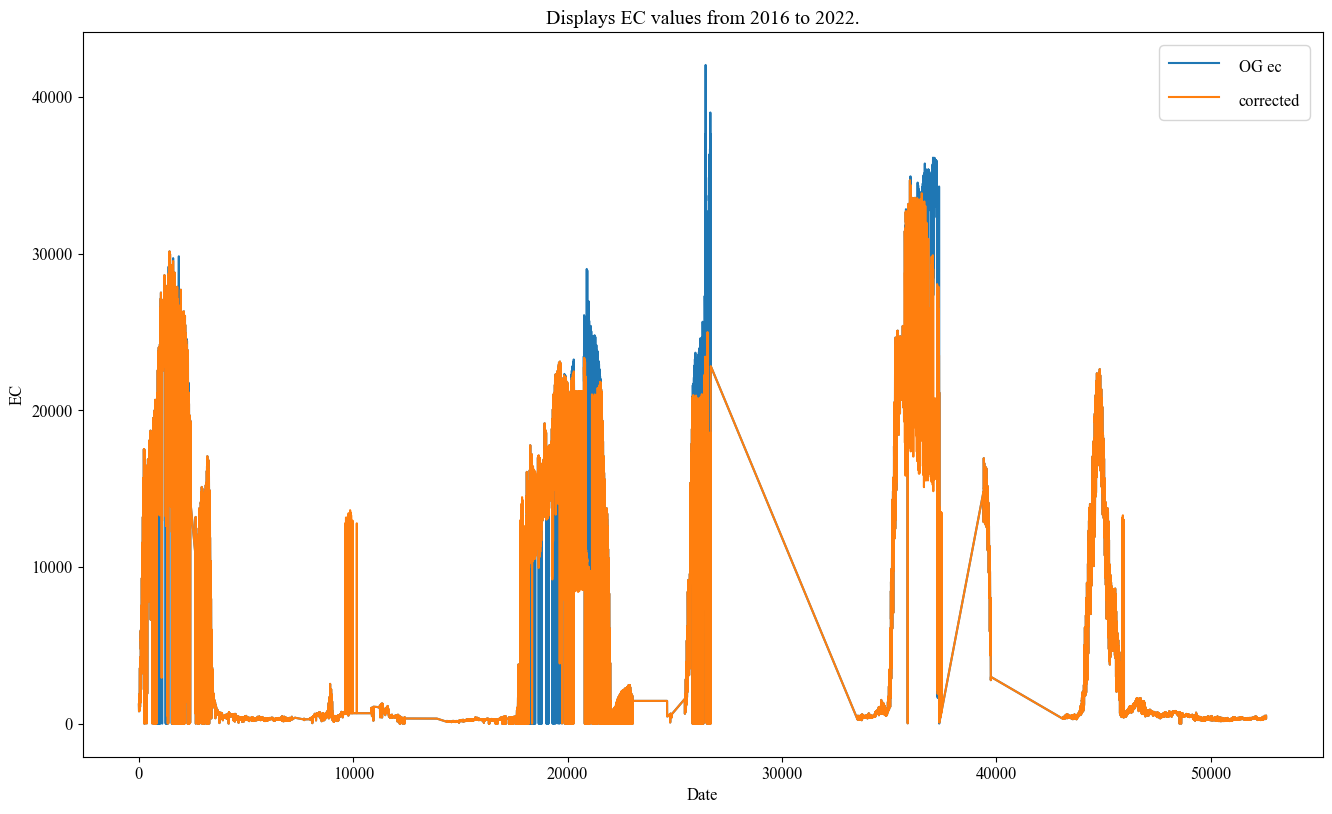

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,32))
plt.subplot(3,1,1)
plt.title('Displays EC values from 2016 to 2022.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df['ec'], label='OG ec')
plt.plot(df['ec_corrected'], label='corrected')
plt.legend()

# plt.subplot(3,1,2)
# plt.title('Displays Temp. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('°C')
# plt.plot(df['temperature'], label='OG temp.')
# plt.plot(df['temp_new_1'], label='temp_new_1')
# plt.plot(df['temp_new_2'], label='temp_new_2')
# plt.plot(df['temp_new_3'], label='temp_new_3')
# plt.plot(df['temp_new_4'], label='temp_new_4')
# plt.plot(df['temp_new_.5'], label='temp_new_.5')
# plt.legend()

# plt.subplot(3,1,3)
# plt.title('Displays pH. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('pH')
# plt.plot(df['pH'], label='OG pH')
# plt.plot(df['pH_new_1'], label='pH_new_1')
# plt.plot(df['pH_new_2'], label='pH_new_2')
# plt.plot(df['pH_new_3'], label='pH_new_3')
# plt.plot(df['pH_new_4'], label='pH_new_4')
# plt.plot(df['pH_new_.5'], label='pH_new_.5')
# plt.legend()

In [6]:
# =============================================================================
# กำหนดตัวแปรที่ต้องการใช้ train ตัว model
# =============================================================================

data = df.filter(['ec_corrected'])
dataset = data.values

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [8]:
# =============================================================================
# MinMaxScaler
# =============================================================================

scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

dataset_scaled = scaler.fit_transform(dataset)

In [9]:
n_future = 24
n_past = 48

In [10]:
# import math

# train_set_len = math.ceil(len(dataset) * 0.80)
# valid_set_len = math.ceil(len(dataset) * 0.10)

# first 3yrs
train_set_len = 26280

# last year
valid_set_len = 17544

In [11]:
# train_set = dataset_scaled[0:train_set_len, :]
train_set = dataset_scaled[0:train_set_len -1, :]


x_train = []
y_train = []

for i in range(n_past, len(train_set) - n_future + 1):
    x_train.append(train_set[i - n_past:i, 0:dataset.shape[1]])
    y_train.append(train_set[i + n_future - 1:i + n_future, 0])

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
valid_set = dataset_scaled[train_set_len - n_past:train_set_len + valid_set_len, :]

x_valid = []
y_valid = []

for i in range(n_past, len(valid_set) - n_future + 1):
    x_valid.append(valid_set[i - n_past:i, 0:dataset.shape[1]])
    y_valid.append(valid_set[i + n_future - 1:i + n_future, 0])

In [14]:
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [15]:
test_set = dataset_scaled[(train_set_len + valid_set_len) - n_past:, :]
test_real = dataset[(train_set_len + valid_set_len) - n_past:, :]

x_test = []
y_test = []

for i in range(n_past, len(test_set) - n_future + 1):
    x_test.append(test_set[i - n_past:i, 0:dataset.shape[1]])
    y_test.append(test_real[i + n_future - 1:i + n_future, 0])

In [16]:
x_test, y_test = np.array(x_test), np.array(y_test)

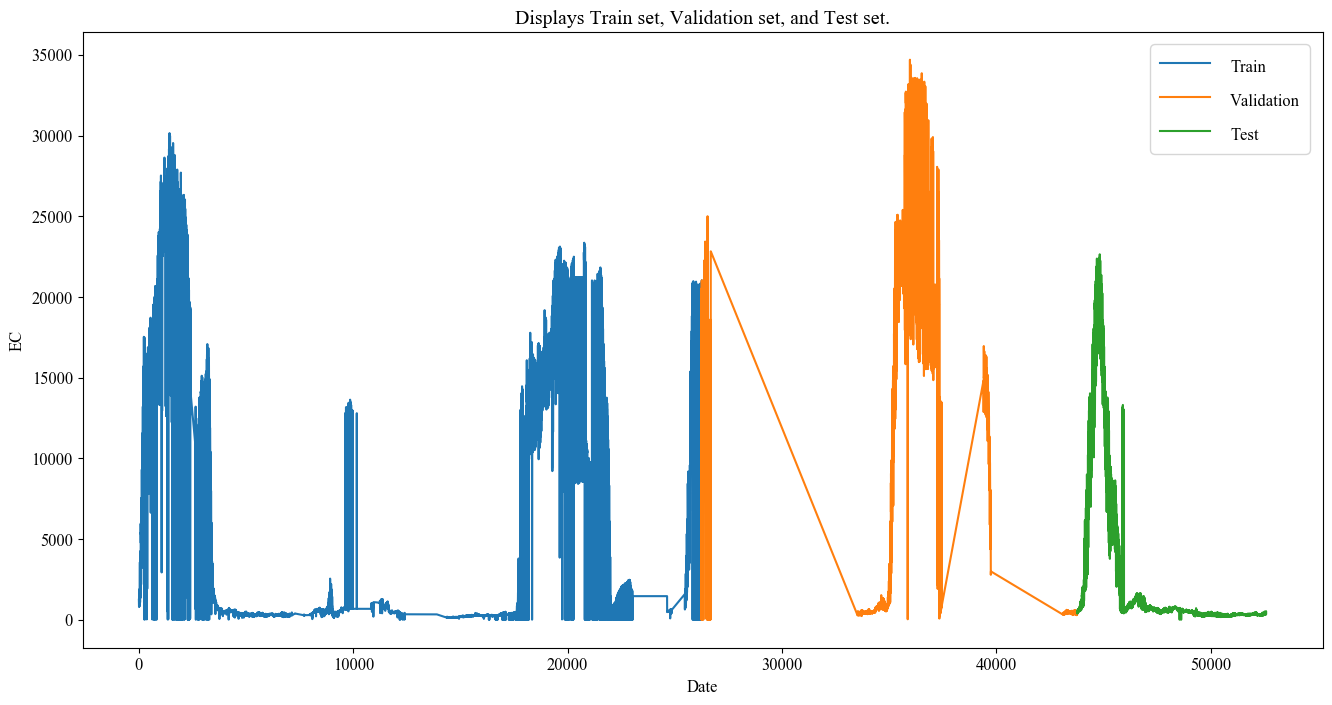

In [17]:
plt.figure(figsize=(16,8))
plt.title('Displays Train set, Validation set, and Test set.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df[0:train_set_len]["ec_corrected"], label='Train')
plt.plot(df[train_set_len - n_past:train_set_len + valid_set_len]["ec_corrected"], label='Validation')
plt.plot(df[(train_set_len + valid_set_len) - n_past:]["ec_corrected"], label='Test')
plt.legend()
plt.show()

In [18]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
# from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
# from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
# =============================================================================
# RNN
# =============================================================================

model = Sequential()
model.add(SimpleRNN(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 48, 128)           16640     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 30,049
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 48, 128)           16640     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None,

In [21]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [22]:
checkpoint_filepath = 'checkpoint/11-rnn-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [23]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1636/1638 [============================>.] - ETA: 0s - loss: 0.0426 - mse: 0.0426
Epoch 1: val_loss improved from inf to 0.01274, saving model to checkpoint\11-rnn-3-2-1.h5
1638/1638 [==============================] - 26s 15ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 2/128
1634/1638 [============================>.] - ETA: 0s - loss: 0.0210 - mse: 0.0210
Epoch 2: val_loss did not improve from 0.01274
1638/1638 [==============================] - 24s 15ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 3/128
1638/1638 [==============================] - ETA: 0s - loss: 0.0285 - mse: 0.0285
Epoch 3: val_loss did not improve from 0.01274
1638/1638 [==============================] - 24s 15ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 4/128
1635/1638 [============================>.] - ETA: 0s - loss: 0.0166 - mse: 0.0166
Epoch 4: val_loss did not improve from 0.01274
1638/1638 [======

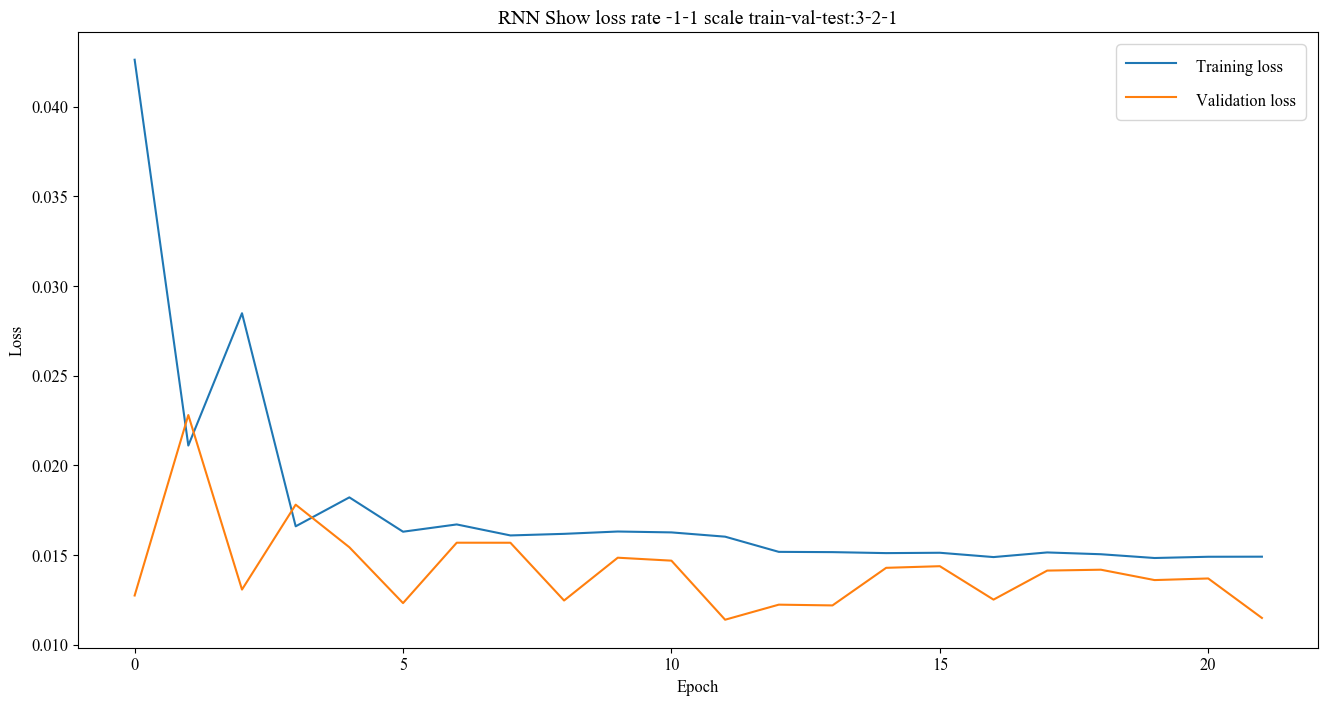

In [26]:
plt.figure(figsize=(16,8))
plt.title('RNN Show loss rate -1-1 scale train-val-test:3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [27]:
from keras.models import load_model

model = load_model('checkpoint/11-rnn-3-2-1.h5')

In [28]:
pred = model.predict(x_test)

274/274 [==============================] - 2s 5ms/step


In [29]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [30]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [31]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [32]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE = {rmse}')            

RMSE = 810.3102046944839


In [33]:
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
print(f'RMSPE = {rmspe}')

RMSPE = 758.2726157823105


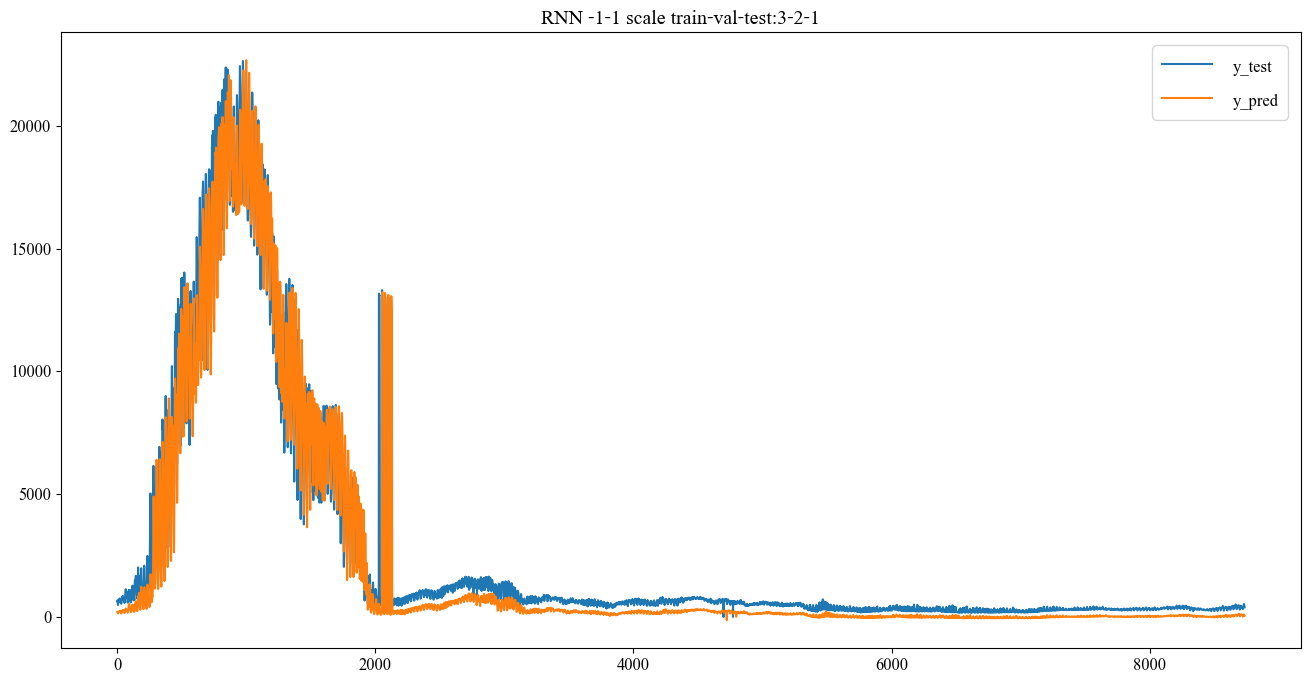

In [35]:
plt.figure(figsize=(16,8))
plt.title('RNN -1-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [36]:
# =============================================================================
# LSTM
# =============================================================================

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 16)               

In [38]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [39]:
checkpoint_filepath = 'checkpoint/11-lstm-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [40]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1636/1638 [============================>.] - ETA: 0s - loss: 0.0166 - mse: 0.0166
Epoch 1: val_loss improved from inf to 0.00897, saving model to checkpoint\11-lstm-3-2-1.h5
1638/1638 [==============================] - 56s 33ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 2/128
1636/1638 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 0.0137
Epoch 2: val_loss did not improve from 0.00897
1638/1638 [==============================] - 54s 33ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 3/128
1636/1638 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 0.0137
Epoch 3: val_loss did not improve from 0.00897
1638/1638 [==============================] - 54s 33ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 4/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0135 - mse: 0.0135
Epoch 4: val_loss did not improve from 0.00897
1638/1638 [=====

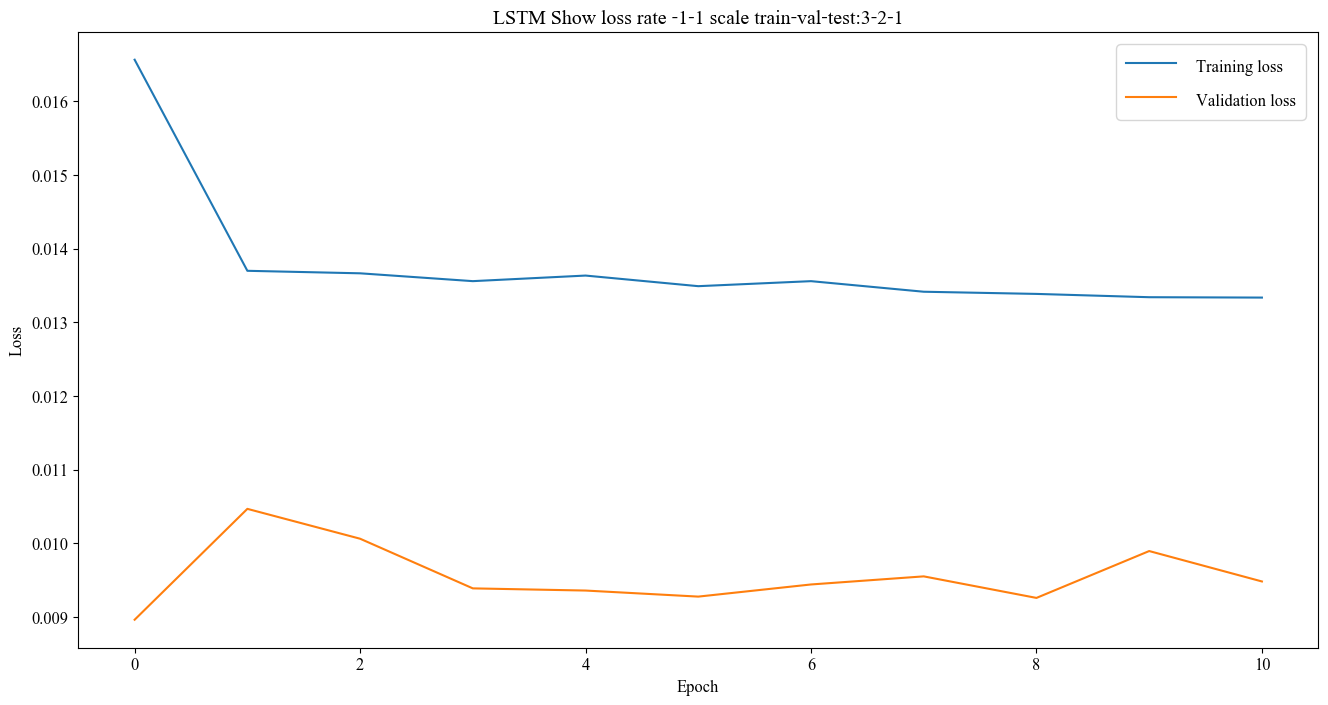

In [41]:
plt.figure(figsize=(16,8))
plt.title('LSTM Show loss rate -1-1 scale train-val-test:3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [42]:
from keras.models import load_model

model = load_model('checkpoint/11-lstm-3-2-1.h5')

In [43]:
pred = model.predict(x_test)

274/274 [==============================] - 5s 16ms/step


In [44]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [45]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [46]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [47]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE = {rmse}')            

RMSE = 722.6765660634329


In [48]:
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
print(f'RMSPE = {rmspe}')

RMSPE = 1929.5448278087645


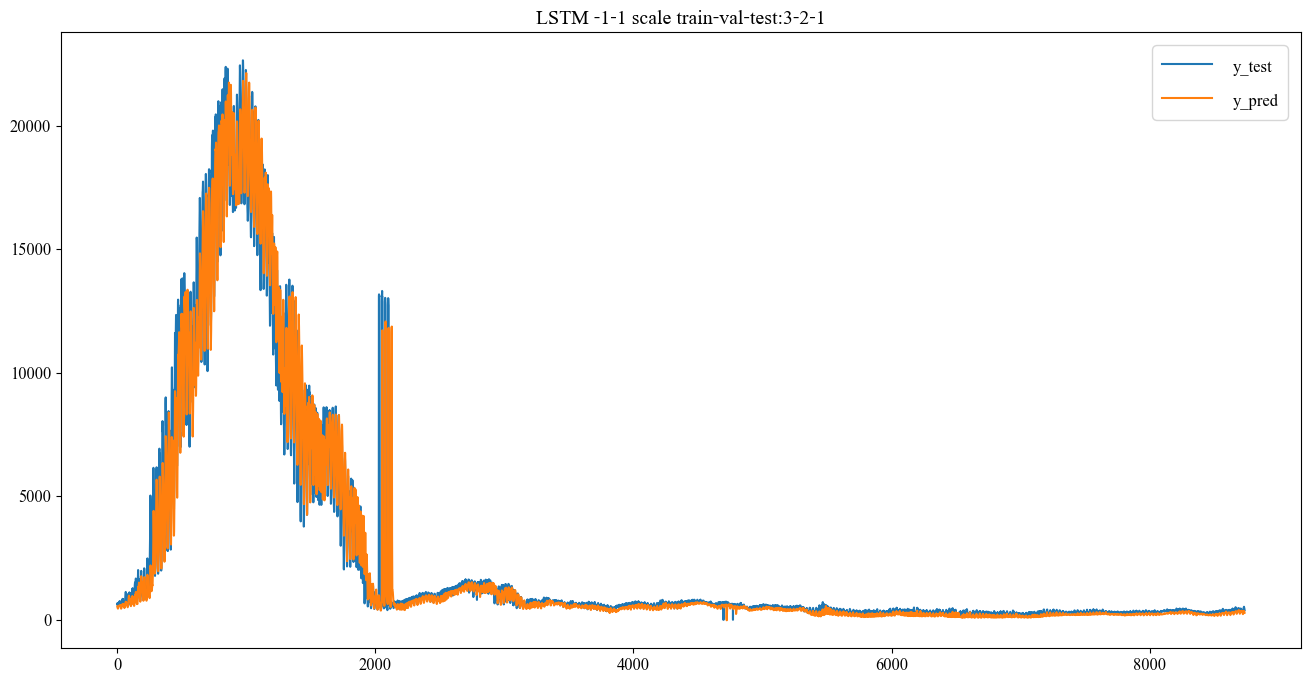

In [49]:
plt.figure(figsize=(16,8))
plt.title('LSTM -1-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [50]:
# =============================================================================
# Bidirectional LSTM
# =============================================================================

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(16))
model.add(Dense(1))

In [51]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 256)         

In [52]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [53]:
checkpoint_filepath = 'checkpoint/11-bilstm-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [54]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0154 - mse: 0.0154
Epoch 1: val_loss improved from inf to 0.00897, saving model to checkpoint\11-bilstm-3-2-1.h5
1638/1638 [==============================] - 84s 49ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 2/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0138 - mse: 0.0138
Epoch 2: val_loss did not improve from 0.00897
1638/1638 [==============================] - 80s 49ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3/128
1638/1638 [==============================] - ETA: 0s - loss: 0.0137 - mse: 0.0137
Epoch 3: val_loss did not improve from 0.00897
1638/1638 [==============================] - 80s 49ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 4/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 0.0137
Epoch 4: val_loss did not improve from 0.00897
1638/1638 [===

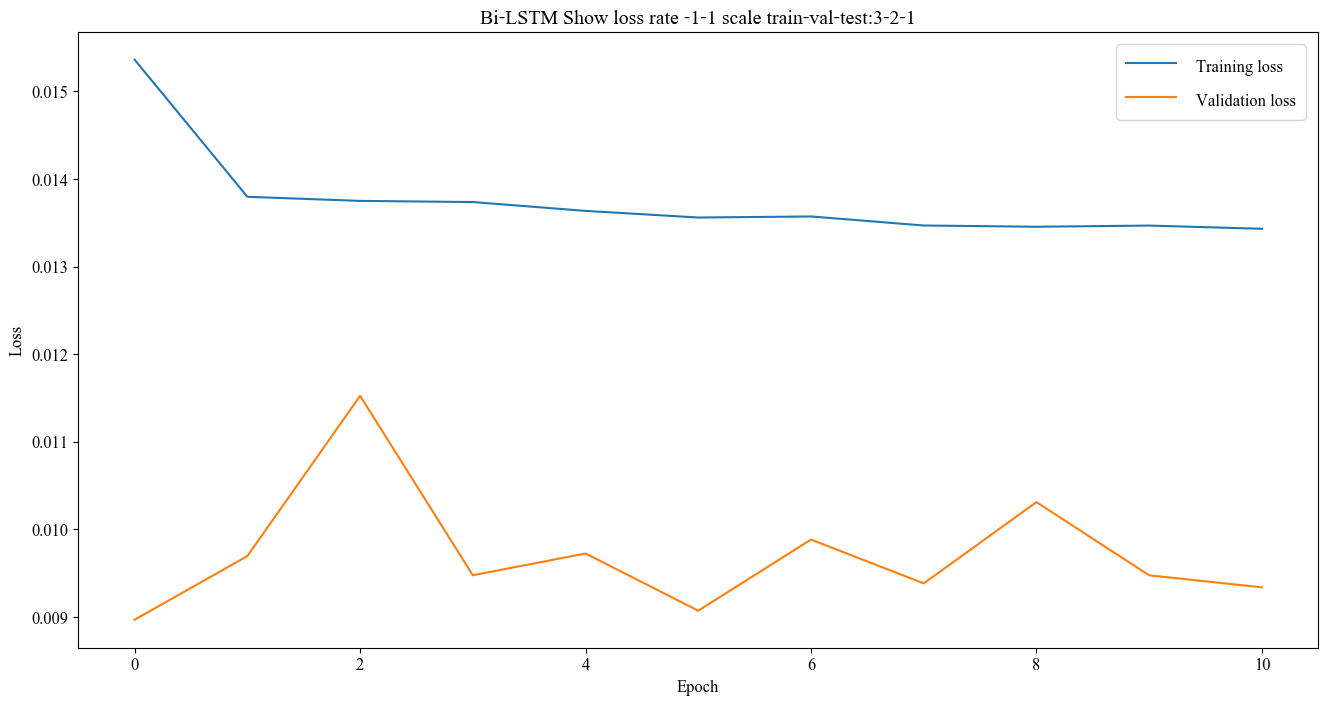

In [55]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM Show loss rate -1-1 scale train-val-test:3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [56]:
from keras.models import load_model

model = load_model('checkpoint/11-bilstm-3-2-1.h5')

In [57]:
pred = model.predict(x_test)

274/274 [==============================] - 8s 24ms/step


In [58]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [59]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [60]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [61]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE = {rmse}')            

RMSE = 719.6384452611115


In [62]:
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
print(f'RMSPE = {rmspe}')

RMSPE = 2252.7494122537737


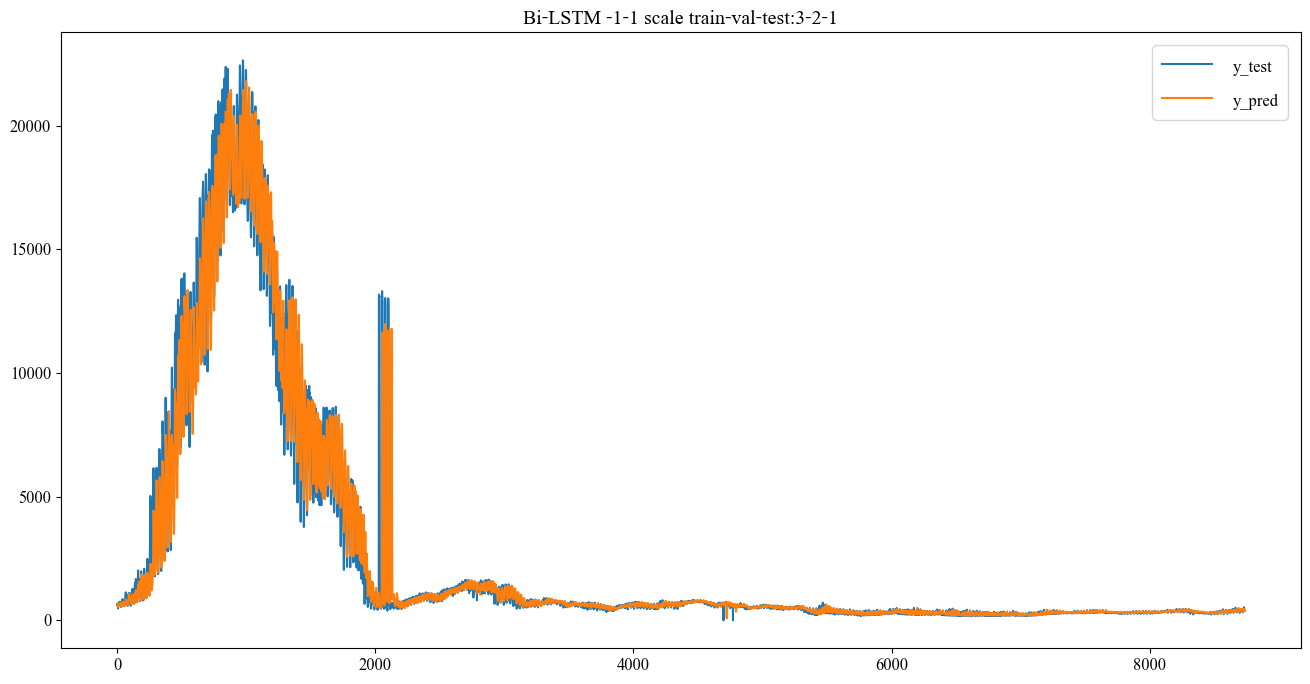

In [63]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM -1-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [64]:
# =============================================================================
# กำหนดตัวแปรที่ต้องการใช้ train ตัว model
# =============================================================================

data = df.filter(['ec_corrected'])
dataset = data.values

In [65]:
# =============================================================================
# MinMaxScaler
# =============================================================================

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

dataset_scaled = scaler.fit_transform(dataset)

In [66]:
n_future = 24
n_past = 48

In [67]:
# import math

# train_set_len = math.ceil(len(dataset) * 0.80)
# valid_set_len = math.ceil(len(dataset) * 0.10)

# first 3yrs
train_set_len = 26280

# last year
valid_set_len = 17544

In [68]:
# train_set = dataset_scaled[0:train_set_len, :]
train_set = dataset_scaled[0:train_set_len -1, :]


x_train = []
y_train = []

for i in range(n_past, len(train_set) - n_future + 1):
    x_train.append(train_set[i - n_past:i, 0:dataset.shape[1]])
    y_train.append(train_set[i + n_future - 1:i + n_future, 0])

In [69]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [70]:
valid_set = dataset_scaled[train_set_len - n_past:train_set_len + valid_set_len, :]

x_valid = []
y_valid = []

for i in range(n_past, len(valid_set) - n_future + 1):
    x_valid.append(valid_set[i - n_past:i, 0:dataset.shape[1]])
    y_valid.append(valid_set[i + n_future - 1:i + n_future, 0])

In [71]:
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [72]:
test_set = dataset_scaled[(train_set_len + valid_set_len) - n_past:, :]
test_real = dataset[(train_set_len + valid_set_len) - n_past:, :]

x_test = []
y_test = []

for i in range(n_past, len(test_set) - n_future + 1):
    x_test.append(test_set[i - n_past:i, 0:dataset.shape[1]])
    y_test.append(test_real[i + n_future - 1:i + n_future, 0])

In [73]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [74]:
# =============================================================================
# RNN
# =============================================================================

model = Sequential()
model.add(SimpleRNN(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

In [75]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 48, 128)           16640     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 30,049
Trainable params: 30,049
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 48, 128)           16640     
                                                                 
 simple_

In [76]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [77]:
checkpoint_filepath = 'checkpoint/01-rnn-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [78]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1634/1638 [============================>.] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 1: val_loss improved from inf to 0.00242, saving model to checkpoint\01-rnn-3-2-1.h5
1638/1638 [==============================] - 26s 15ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/128
1635/1638 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0038
Epoch 2: val_loss did not improve from 0.00242
1638/1638 [==============================] - 24s 15ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 3/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0038
Epoch 3: val_loss did not improve from 0.00242
1638/1638 [==============================] - 25s 15ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/128
1638/1638 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037
Epoch 4: val_loss did not improve from 0.00242
1638/1638 [======

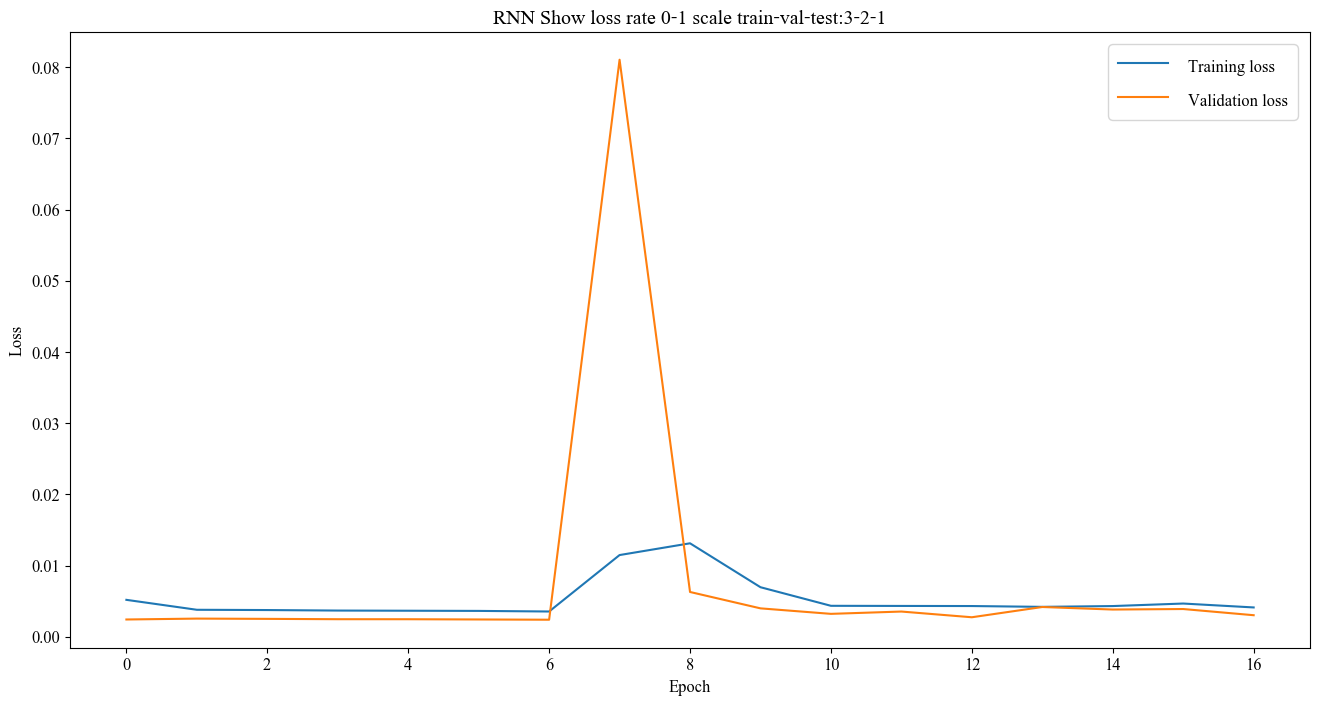

In [80]:
plt.figure(figsize=(16,8))
plt.title('RNN Show loss rate 0-1 scale train-val-test:3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [81]:
from keras.models import load_model

model = load_model('checkpoint/01-rnn-3-2-1.h5')

In [82]:
pred = model.predict(x_test)

274/274 [==============================] - 2s 7ms/step


In [83]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [84]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [85]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [86]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE = {rmse}')            

RMSE = 745.2420560679922


In [87]:
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
print(f'RMSPE = {rmspe}')

RMSPE = 2433.5149608921815


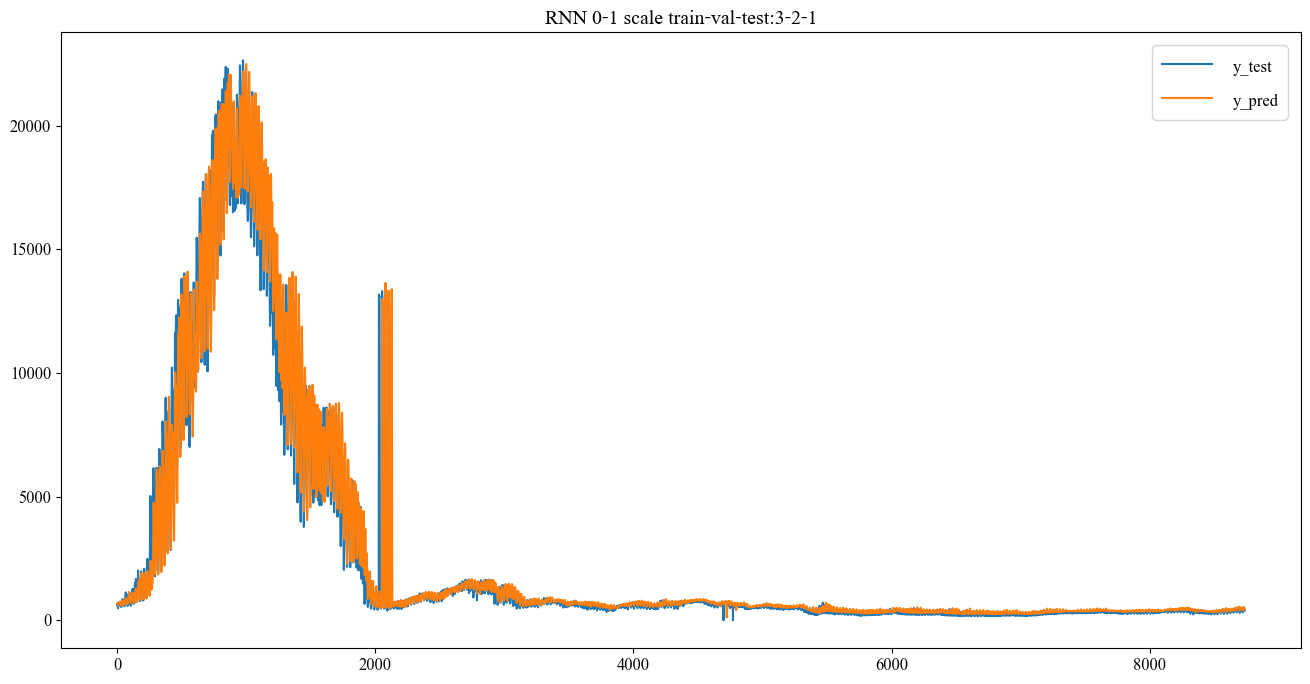

In [88]:
plt.figure(figsize=(16,8))
plt.title('RNN 0-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [89]:
# =============================================================================
# LSTM
# =============================================================================

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

In [90]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 48, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 117,025
Trainable params: 117,025
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 48, 128)           66560     
                                                                 
 lstm_

In [91]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [92]:
checkpoint_filepath = 'checkpoint/01-lstm-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [93]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1638/1638 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040
Epoch 1: val_loss improved from inf to 0.00550, saving model to checkpoint\01-lstm-3-2-1.h5
1638/1638 [==============================] - 76s 45ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 2/128
1638/1638 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036
Epoch 2: val_loss improved from 0.00550 to 0.00258, saving model to checkpoint\01-lstm-3-2-1.h5
1638/1638 [==============================] - 71s 43ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/128
1638/1638 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035
Epoch 3: val_loss improved from 0.00258 to 0.00239, saving model to checkpoint\01-lstm-3-2-1.h5
1638/1638 [==============================] - 71s 44ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/128
1638/1638 [==============================] - ET

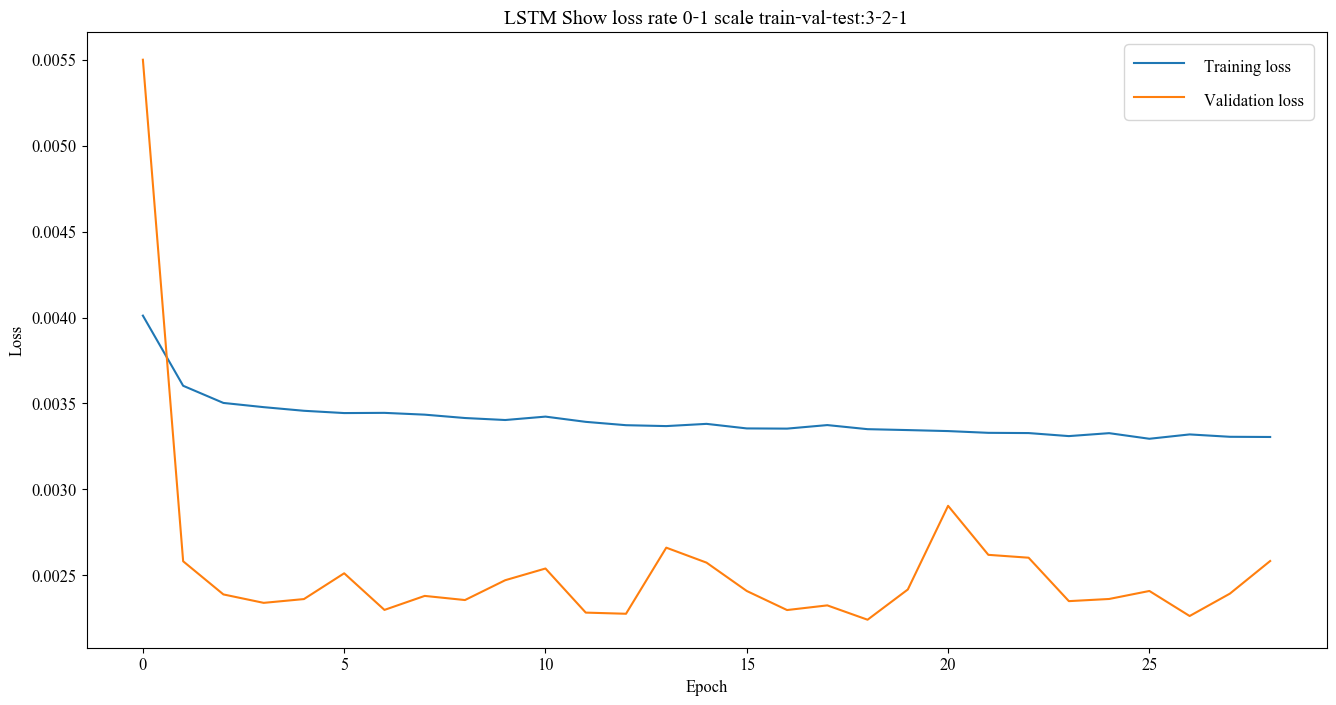

In [94]:
plt.figure(figsize=(16,8))
plt.title('LSTM Show loss rate 0-1 scale train-val-test:3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [95]:
from keras.models import load_model

model = load_model('checkpoint/01-lstm-3-2-1.h5')

In [96]:
pred = model.predict(x_test)

274/274 [==============================] - 8s 27ms/step


In [97]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [98]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [99]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [100]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE = {rmse}')            

RMSE = 713.5346837994066


In [101]:
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
print(f'RMSPE = {rmspe}')

RMSPE = 2072.1870462012225


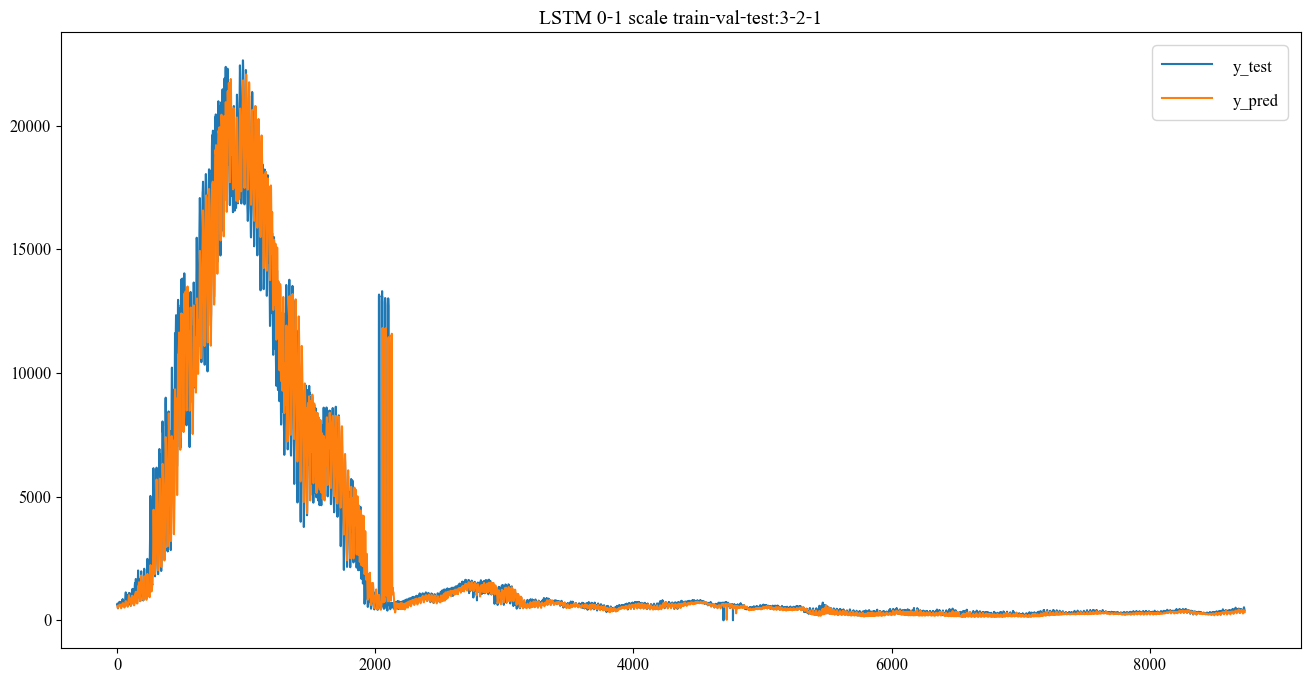

In [102]:
plt.figure(figsize=(16,8))
plt.title('LSTM 0-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [103]:
# =============================================================================
# Bidirectional LSTM
# =============================================================================

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(16))
model.add(Dense(1))

In [104]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 48, 256)          133120    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 48, 256)         

In [105]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [106]:
checkpoint_filepath = 'checkpoint/01-bilstm-3-2-1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [107]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
1638/1638 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039
Epoch 1: val_loss improved from inf to 0.00255, saving model to checkpoint\01-bilstm-3-2-1.h5
1638/1638 [==============================] - 107s 63ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 2/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0036
Epoch 2: val_loss did not improve from 0.00255
1638/1638 [==============================] - 99s 61ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0035 - mse: 0.0035
Epoch 3: val_loss did not improve from 0.00255
1638/1638 [==============================] - 102s 62ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 4/128
1637/1638 [============================>.] - ETA: 0s - loss: 0.0035 - mse: 0.0035
Epoch 4: val_loss did not improve from 0.00255
1638/1638 [=

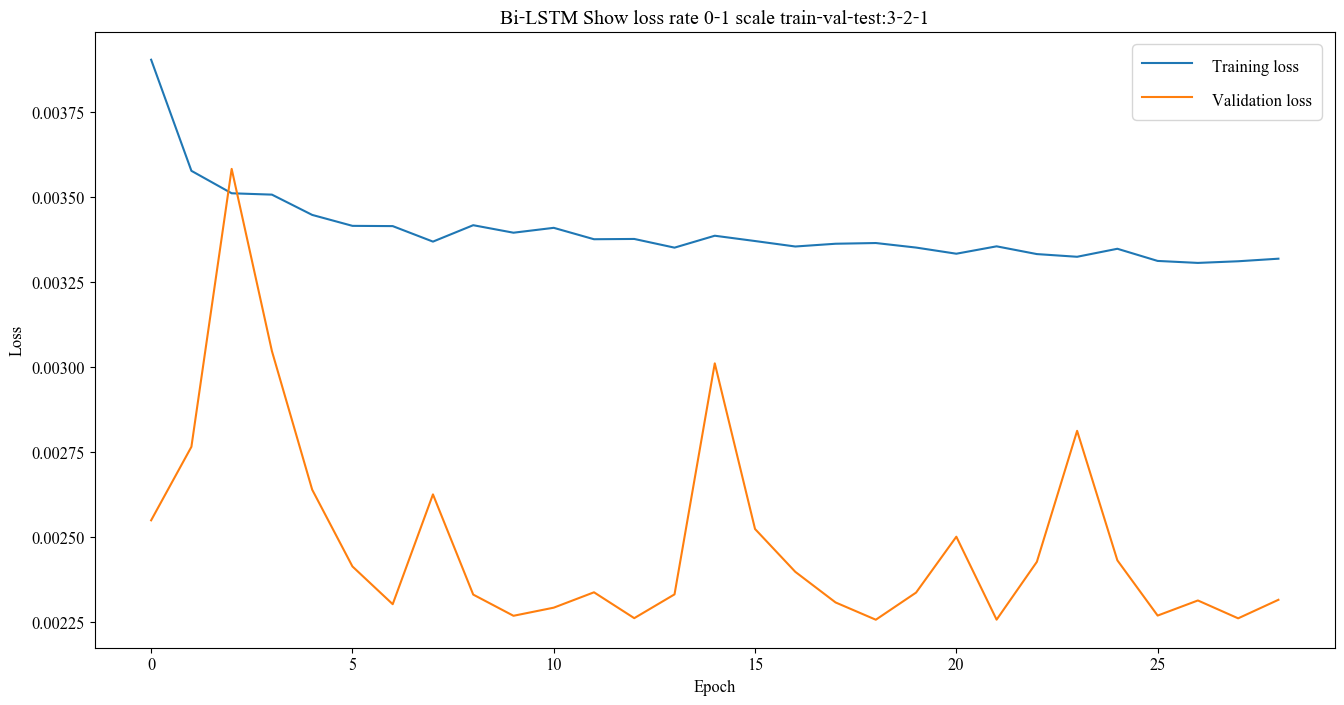

In [108]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM Show loss rate 0-1 scale train-val-test:3-2-1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [109]:
from keras.models import load_model

model = load_model('checkpoint/01-bilstm-3-2-1.h5')

In [110]:
pred = model.predict(x_test)

274/274 [==============================] - 10s 34ms/step


In [111]:
if dataset.shape[1] > 1:
    pred = np.repeat(pred, dataset.shape[1], axis=-1)

In [112]:
y_pred = scaler.inverse_transform(pred)[:,0]

In [113]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [114]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE = {rmse}')            

RMSE = 742.4156932407581


In [115]:
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
print(f'RMSPE = {rmspe}')

RMSPE = 1555.1757054733162


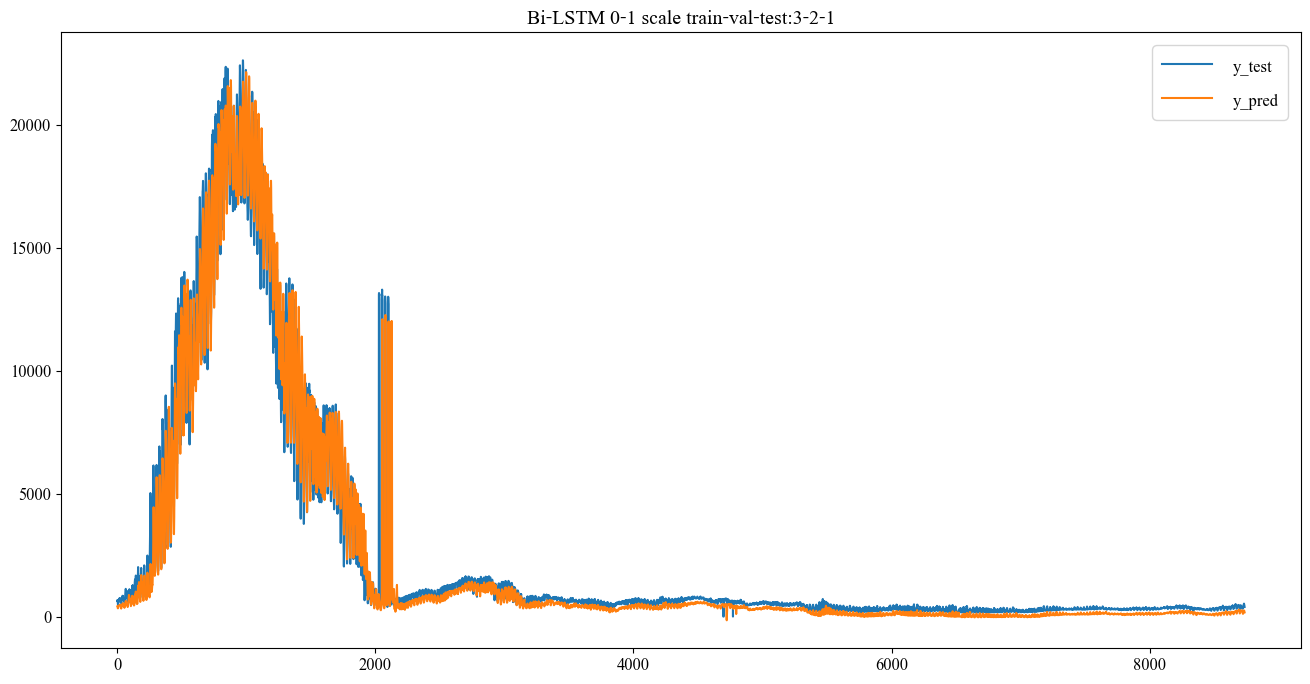

In [116]:
plt.figure(figsize=(16,8))
plt.title('Bi-LSTM 0-1 scale train-val-test:3-2-1')
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()